In [1]:
import pandas as pd
import numpy as np
import time
import gc
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from s3fs.core import S3FileSystem


def global_map_plot(df, variable, vmin, vmax, cmap, title):
    # get new coordinate
    df["lon_new"] = np.where(df['lon'] <= 180, df['lon'], df['lon']-360)

    plt.figure(figsize=(18, 12))
    map = Basemap()
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawmeridians(range(0, 360, 30),labels=[True,False,False,True],fontsize=20)
    map.drawparallels(range(-90, 100, 30), labels=[True,False,False,True],fontsize=20)
    if cmap == "bwr":
        map.fillcontinents(zorder=0)
    plt.scatter(df["lon_new"], df["lat"], 
                c=df[variable],
                s=6, cmap=cmap, vmin=vmin, vmax=vmax)
    clb = plt.colorbar(orientation="vertical",fraction = 0.023, pad=0.01)
    clb.ax.tick_params(labelsize=20)
    #plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1)
    plt.savefig("./"+title+"_rmse.pdf")
    plt.show()

## Save the necessary files

In [2]:
s3 = S3FileSystem()
validation_path = "/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/"
save_dir = "S3://uhws/UHWs_CESM/model-validation/"

def workflow(start_year, validation_path, save_dir):
    rmse_by_lat_lon_ls = []
    rmse_by_lat_lon_overall_ls = []
    rmse_overall_ls = []
    
    for i in range(2,34):
        member = (str(i).zfill(3))
        print("member:",member)
        t_0 = time.time()
        df=pd.read_csv(validation_path+start_year+"/"+member+"_ens.csv")
        print("It took", time.time()-t_0, "to load csv")
        
        t_1 = time.time()
        rmse_by_lat_lon = df.groupby(["lat","lon"])\
                           .apply(lambda df: np.sqrt(mean_squared_error(df[member], 
                                                     df["TREFMXAV_U"])))
        rmse_by_lat_lon_ls.append(rmse_by_lat_lon)
        
        # calculate the rmse groupped by lat/lon first, then calcuate the mean of overall gridcell
        rmse_by_lat_lon_overall = rmse_by_lat_lon.mean()
        rmse_by_lat_lon_overall_ls.append(rmse_by_lat_lon_overall)
        #print("Mean of rmse groupped by lat/lon is:", rmse_by_lat_lon_mean)
        
        # calcuate the mean of all gridcell directly (regardless of lat/lon)
        rmse_overall = mean_squared_error(df[member],df["TREFMXAV_U"])
        rmse_overall_ls.append(rmse_overall)
        #print("Overall rmse without groupby is:", rmse_overall)
        
        del df, rmse_by_lat_lon, rmse_by_lat_lon_overall, rmse_overall
        gc.collect()
        print("It took", time.time()-t_1, "to finish",member)
        print("\n")
    
    print("rmse by lat/lon")
    rmse_by_lat_lon=pd.concat(rmse_by_lat_lon_ls,axis=1)
    print("shape of rmse by lat/lon",rmse_by_lat_lon.shape)
    rmse_by_lat_lon.to_csv(save_dir+start_year+"/rmse_by_lat_lon.csv")
    del rmse_by_lat_lon_ls
    gc.collect()
    print("\n")
    
    print("mean of rmse by lat/lon")
    rmse_by_lat_lon_mean = rmse_by_lat_lon.mean(axis=1)
    display(rmse_by_lat_lon_mean.describe())
    rmse_by_lat_lon_mean.to_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv")
    del rmse_by_lat_lon
    gc.collect()
    print("\n")
    
    print("mean of mean of overall gridcell")
    rmse_by_lat_lon_overall=np.asarray(rmse_by_lat_lon_overall_ls)
    print("mean:",rmse_by_lat_lon_overall.mean())
    np.savetxt("./"+start_year+"/rmse_by_lat_lon_overall.txt",rmse_by_lat_lon_overall)
    del rmse_by_lat_lon_overall, rmse_by_lat_lon_overall_ls
    gc.collect()
    print("\n")
    
    
    print("mean of overall gridcell")
    rmse_overall=np.asarray(rmse_overall_ls)
    print("mean:",rmse_overall.mean())
    np.savetxt("./"+start_year+"/rmse_overall.txt",rmse_overall)
    del rmse_overall, rmse_overall_ls
    gc.collect()
    print("\n")
    
    return rmse_by_lat_lon_mean

## Save the necessary files

### 2006

In [3]:
start_year = "2006"
df_2006 = workflow(start_year, validation_path, save_dir)

member: 002
It took 10.558691024780273 to load csv
It took 5.5507378578186035 to finish 002


member: 003
It took 10.432186841964722 to load csv
It took 5.135367393493652 to finish 003


member: 004
It took 10.26073431968689 to load csv
It took 5.078200578689575 to finish 004


member: 005
It took 10.314345359802246 to load csv
It took 5.191688060760498 to finish 005


member: 006
It took 10.274330615997314 to load csv
It took 5.327561140060425 to finish 006


member: 007
It took 10.395832538604736 to load csv
It took 5.410783529281616 to finish 007


member: 008
It took 10.679191827774048 to load csv
It took 5.089076995849609 to finish 008


member: 009
It took 10.606933355331421 to load csv
It took 5.6604392528533936 to finish 009


member: 010
It took 10.658734321594238 to load csv
It took 5.610315561294556 to finish 010


member: 011
It took 10.319018602371216 to load csv
It took 4.893005847930908 to finish 011


member: 012
It took 10.526528596878052 to load csv
It took 5.62635445

count    4439.000000
mean        0.728594
std         0.283106
min         0.129773
25%         0.514821
50%         0.723261
75%         0.895908
max         1.726327
dtype: float64



mean of mean of overall gridcell
mean: 0.7285944682475628


mean of overall gridcell
mean: 0.6117285640195493




### 2061

In [4]:
start_year = "2061"
df_2061 = workflow(start_year, validation_path, save_dir)

member: 002
It took 10.271963834762573 to load csv
It took 4.897156715393066 to finish 002


member: 003
It took 10.270943641662598 to load csv
It took 4.9811179637908936 to finish 003


member: 004
It took 13.577999830245972 to load csv
It took 5.014472484588623 to finish 004


member: 005
It took 11.078337907791138 to load csv
It took 5.120688199996948 to finish 005


member: 006
It took 12.54755711555481 to load csv
It took 5.616602659225464 to finish 006


member: 007
It took 12.14312481880188 to load csv
It took 5.491536855697632 to finish 007


member: 008
It took 10.448881149291992 to load csv
It took 5.095868110656738 to finish 008


member: 009
It took 11.783947944641113 to load csv
It took 5.609994173049927 to finish 009


member: 010
It took 13.906949281692505 to load csv
It took 5.62089204788208 to finish 010


member: 011
It took 11.173503160476685 to load csv
It took 5.076585292816162 to finish 011


member: 012
It took 12.157440185546875 to load csv
It took 5.12178182601

count    4439.000000
mean        0.725304
std         0.263574
min         0.111506
25%         0.535996
50%         0.732210
75%         0.880012
max         1.695290
dtype: float64



mean of mean of overall gridcell
mean: 0.7253035489415137


mean of overall gridcell
mean: 0.5962535668484408




## Visualization

### 2006

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.728594
std,25.646228,111.895429,0.283106
min,-54.188499,0.000000,0.129773
25%,8.952900,36.250000,0.514821
50%,29.685900,100.000000,0.723261
75%,42.879601,260.000000,0.895908
max,70.209396,358.750000,1.726327


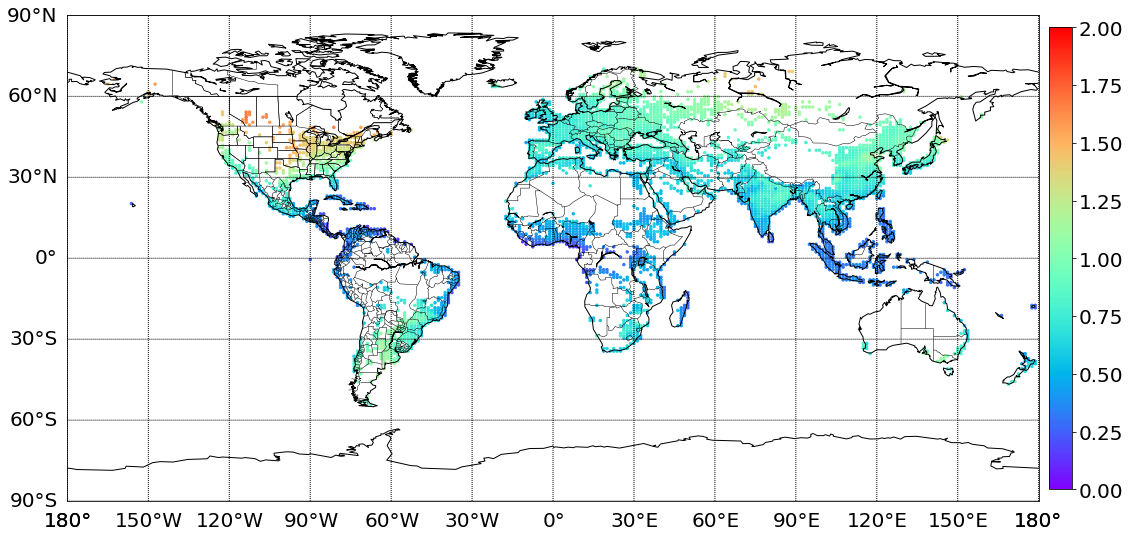

In [3]:
start_year="2006"
df_2006 = pd.read_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv")
display(df_2006.describe())
global_map_plot(df_2006, "0", 0, 2, "rainbow","2006")

### 2061

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.725304
std,25.646228,111.895429,0.263574
min,-54.188499,0.000000,0.111506
25%,8.952900,36.250000,0.535996
50%,29.685900,100.000000,0.732210
75%,42.879601,260.000000,0.880012
max,70.209396,358.750000,1.695290


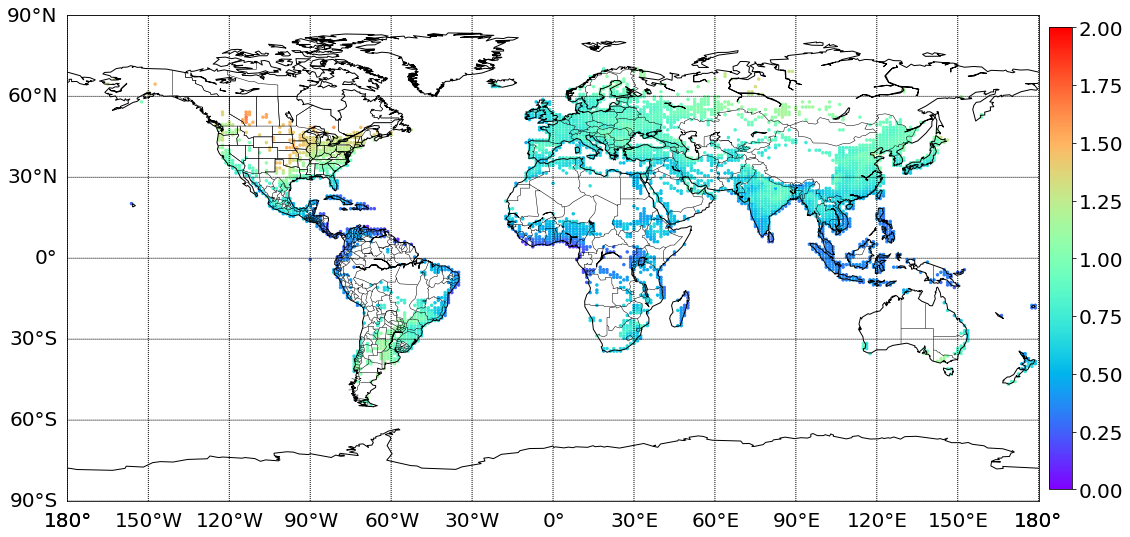

In [4]:
start_year="2061"
df_2061 = pd.read_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv")
display(df_2061.describe())
global_map_plot(df_2061, "0", 0, 2, "rainbow","2061")